## Bike sharing Time Series

### Importing libraries

In [1]:
library(workflows)
library(parsnip)
library(recipes)
library(yardstick)
library(glmnet)
library(tidyverse)
library(tidyquant)
library(timetk)

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'recipes'


The following object is masked from 'package:stats':

    step


For binary classification, the first factor level is assumed to be the event.
Use the argument `event_level = "second"` to alter this as needed.

Loading required package: Matrix

Loaded glmnet 4.0-2

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v stringr 1.4.0
v tidyr   1.1.1     v forcats 0.5.0
v readr   1.3.1     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand()  masks Matrix::expand()
x dplyr::filter()  masks stats::filter()
x stringr::fixed() masks recipes::fixed()
x dplyr::lag()     masks stats::lag()
x tidyr::pac

### Reading and understanding the data

In [2]:
bikes <- read_csv('day.csv')

Parsed with column specification:
cols(
  instant = col_double(),
  dteday = col_date(format = ""),
  season = col_double(),
  yr = col_double(),
  mnth = col_double(),
  holiday = col_double(),
  weekday = col_double(),
  workingday = col_double(),
  weathersit = col_double(),
  temp = col_double(),
  atemp = col_double(),
  hum = col_double(),
  windspeed = col_double(),
  casual = col_double(),
  registered = col_double(),
  cnt = col_double()
)



In [3]:
head(bikes)

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


In [4]:
bikes_tbl <- bikes %>% select(dteday, cnt) %>% rename(date = dteday, value = cnt)

In [5]:
head(bikes_tbl)

date,value
<date>,<dbl>
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
2011-01-06,1606


### Visualizing the data

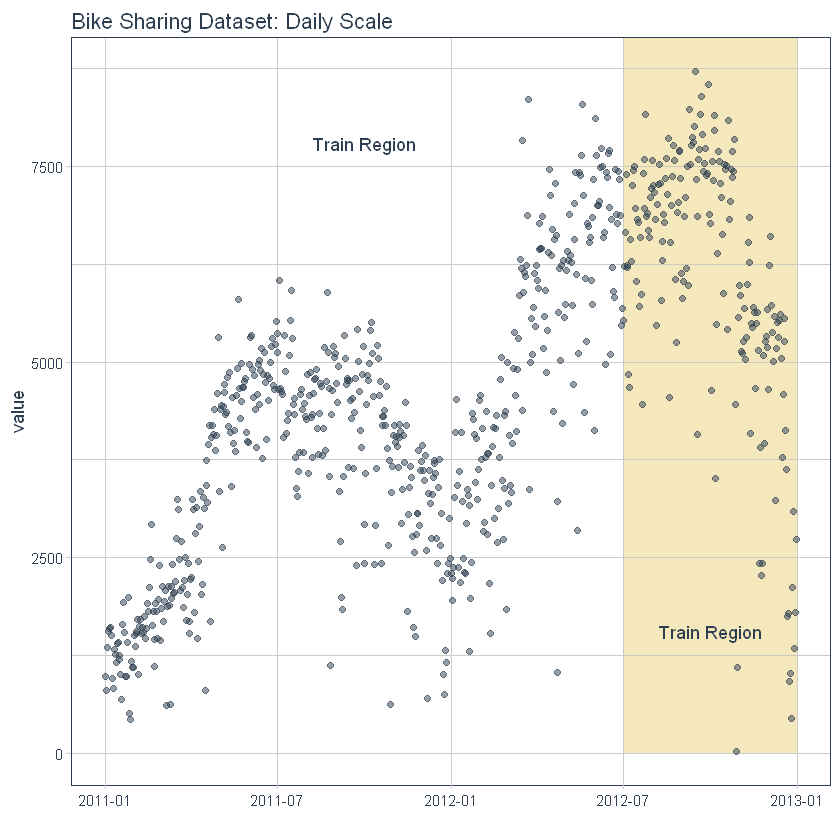

In [6]:
bikes_tbl %>% 
    ggplot(aes(x=date, y=value)) + 
    geom_rect(xmin = as.numeric(ymd('2012-07-01')),
              xmax = as.numeric(ymd('2013-01-01')),
              ymin = 0, ymax = 10000,
              fill = palette_light()[[4]], alpha = 0.01) +
    annotate("text", x = ymd('2011-10-01'), y = 7800,
            color = palette_light()[[1]], label = 'Train Region') +
    annotate("text", x = ymd('2012-10-01'), y = 1550,
            color = palette_light()[[1]], label = 'Train Region') +
    geom_point(alpha = 0.5, color = palette_light()[[1]]) +
    labs(title = 'Bike Sharing Dataset: Daily Scale', x="") +
    theme_tq()

### Splitting data

In [7]:
train_tbl <- bikes_tbl %>% filter(date < ymd("2012-07-01"))
test_tbl <- bikes_tbl %>% filter(date >= ymd("2012-07-01")) 

### Modeling

In [8]:
recipe_spec_timeseries <- recipe(value ~., data =train_tbl) %>%
    step_timeseries_signature(date)

### Feature Engineering

In [9]:
bake(prep(recipe_spec_timeseries), new_data = train_tbl)

date,value,date_index.num,date_year,date_year.iso,date_half,date_quarter,date_month,date_month.xts,date_month.lbl,...,date_mday,date_qday,date_yday,date_mweek,date_week,date_week.iso,date_week2,date_week3,date_week4,date_mday7
<date>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<ord>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2011-01-01,985,1293840000,2011,2010,1,1,1,0,January,...,1,1,1,1,1,52,1,1,1,1
2011-01-02,801,1293926400,2011,2010,1,1,1,0,January,...,2,2,2,2,1,52,1,1,1,1
2011-01-03,1349,1294012800,2011,2011,1,1,1,0,January,...,3,3,3,2,1,1,1,1,1,1
2011-01-04,1562,1294099200,2011,2011,1,1,1,0,January,...,4,4,4,2,1,1,1,1,1,1
2011-01-05,1600,1294185600,2011,2011,1,1,1,0,January,...,5,5,5,2,1,1,1,1,1,1
2011-01-06,1606,1294272000,2011,2011,1,1,1,0,January,...,6,6,6,2,1,1,1,1,1,1
2011-01-07,1510,1294358400,2011,2011,1,1,1,0,January,...,7,7,7,2,1,1,1,1,1,2
2011-01-08,959,1294444800,2011,2011,1,1,1,0,January,...,8,8,8,2,2,1,0,2,2,2
2011-01-09,822,1294531200,2011,2011,1,1,1,0,January,...,9,9,9,3,2,1,0,2,2,2


In [10]:
recipe_spec_final <- recipe_spec_timeseries %>%
    step_rm(date) %>%
    step_rm(contains("iso"), 
            contains("second"), contains("minute"), contains("hour"),
            contains("am.pm"), contains("xts")) %>%
    step_normalize(contains("index.num"), date_year) %>%
    step_interact(~ date_month.lbl * date_day) %>%
    step_interact(~ date_month.lbl * date_mweek) %>%
    step_interact(~ date_month.lbl * date_wday.lbl * date_yday) %>%
    step_dummy(contains("lbl"), one_hot = TRUE) 

bake(prep(recipe_spec_final), new_data = train_tbl)

Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"The following variables are not factor vectors and will be ignored: `date_month.lbl.L_x_date_day`, `date_month.lbl.Q_x_date_day`, `date_month.lbl.C_x_date_day`, `date_month.lbl^4_x_date_day`, `date_month.lbl^5_x_date_day`, `date_month.lbl^6_

value,date_index.num,date_year,date_half,date_quarter,date_month,date_day,date_wday,date_mday,date_qday,...,date_month.lbl_10,date_month.lbl_11,date_month.lbl_12,date_wday.lbl_1,date_wday.lbl_2,date_wday.lbl_3,date_wday.lbl_4,date_wday.lbl_5,date_wday.lbl_6,date_wday.lbl_7
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
985,-1.727306,-0.7054917,1,1,1,1,7,1,1,...,0,0,0,0,0,0,0,0,0,1
801,-1.720979,-0.7054917,1,1,1,2,1,2,2,...,0,0,0,1,0,0,0,0,0,0
1349,-1.714652,-0.7054917,1,1,1,3,2,3,3,...,0,0,0,0,1,0,0,0,0,0
1562,-1.708325,-0.7054917,1,1,1,4,3,4,4,...,0,0,0,0,0,1,0,0,0,0
1600,-1.701998,-0.7054917,1,1,1,5,4,5,5,...,0,0,0,0,0,0,1,0,0,0
1606,-1.695671,-0.7054917,1,1,1,6,5,6,6,...,0,0,0,0,0,0,0,1,0,0
1510,-1.689343,-0.7054917,1,1,1,7,6,7,7,...,0,0,0,0,0,0,0,0,1,0
959,-1.683016,-0.7054917,1,1,1,8,7,8,8,...,0,0,0,0,0,0,0,0,0,1
822,-1.676689,-0.7054917,1,1,1,9,1,9,9,...,0,0,0,1,0,0,0,0,0,0


### Model Specification

In [11]:
model_spec_glmnet <- linear_reg(mode = "regression", penalty = 10, mixture = 0.7) %>%
    set_engine("glmnet")

### Workflow

In [12]:
workflow_glmnet <- workflow() %>%
    add_recipe(recipe_spec_final) %>%
    add_model(model_spec_glmnet)

workflow_glmnet

== Workflow ====================================================================
Preprocessor: Recipe
Model: linear_reg()

-- Preprocessor ----------------------------------------------------------------
8 Recipe Steps

* step_timeseries_signature()
* step_rm()
* step_rm()
* step_normalize()
* step_interact()
* step_interact()
* step_interact()
* step_dummy()

-- Model -----------------------------------------------------------------------
Linear Regression Model Specification (regression)

Main Arguments:
  penalty = 10
  mixture = 0.7

Computational engine: glmnet 


### Training

In [13]:
workflow_trained <- workflow_glmnet %>% fit(data = train_tbl)

Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"The following variables are not factor vectors and will be ignored: `date_month.lbl.L_x_date_day`, `date_month.lbl.Q_x_date_day`, `date_month.lbl.C_x_date_day`, `date_month.lbl^4_x_date_day`, `date_month.lbl^5_x_date_day`, `date_month.lbl^6_

### Visualizing the Test Forcast

In [14]:
prediction_tbl <- workflow_trained %>% 
    predict(test_tbl) %>%
    bind_cols(test_tbl) 

head(prediction_tbl)

.pred,date,value
<dbl>,<date>,<dbl>
7062.987,2012-07-01,5531
7094.197,2012-07-02,6227
7049.158,2012-07-03,6660
7012.324,2012-07-04,7403
7024.955,2012-07-05,6241
7018.081,2012-07-06,6207


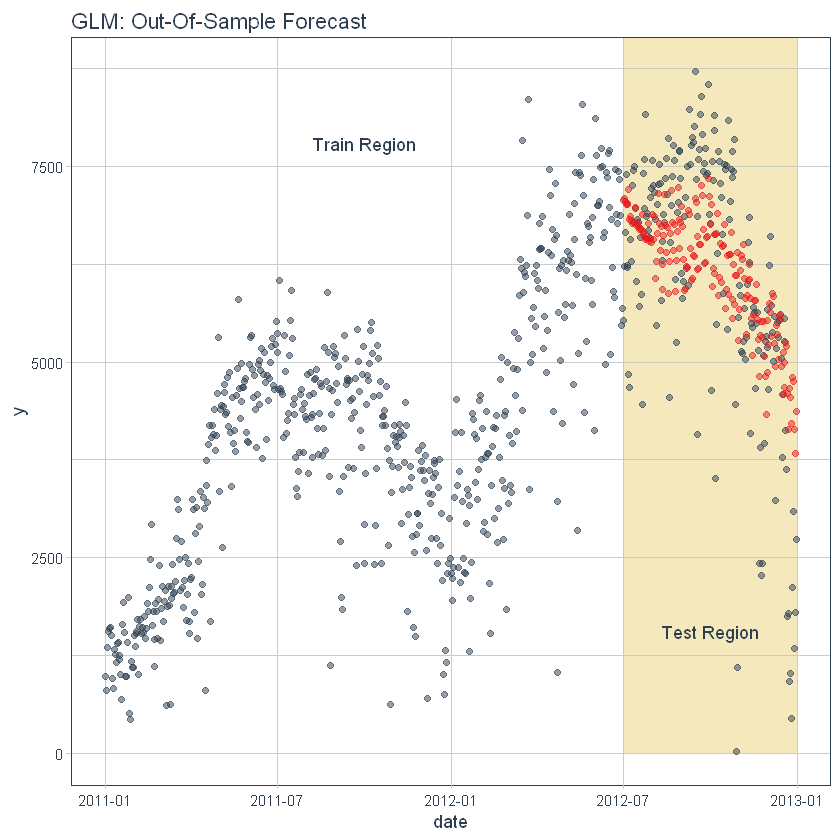

In [15]:
ggplot(aes(x = date), data = bikes_tbl) +
    geom_rect(xmin = as.numeric(ymd("2012-07-01")),
              xmax = as.numeric(ymd("2013-01-01")),
              ymin = 0, ymax = 10000,
              fill = palette_light()[[4]], alpha = 0.01) +
    annotate("text", x = ymd("2011-10-01"), y = 7800,
             color = palette_light()[[1]], label = "Train Region") +
    annotate("text", x = ymd("2012-10-01"), y = 1550,
             color = palette_light()[[1]], label = "Test Region") + 
    geom_point(aes(x = date, y = value),  
               alpha = 0.5, color = palette_light()[[1]]) +
    geom_point(aes(x = date, y = .pred), data = prediction_tbl, 
               alpha = 0.5, color = palette_light()[[2]]) +
    theme_tq() +
    labs(title = "GLM: Out-Of-Sample Forecast")

### Validation Accuracy

In [16]:
prediction_tbl %>% metrics(value, .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1385.4131103
rsq,standard,0.4134193
mae,standard,1028.7137107


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"k-d tree limited by memory. ncmax= 200"
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"k-d tree limited by memory. ncmax= 200"
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."


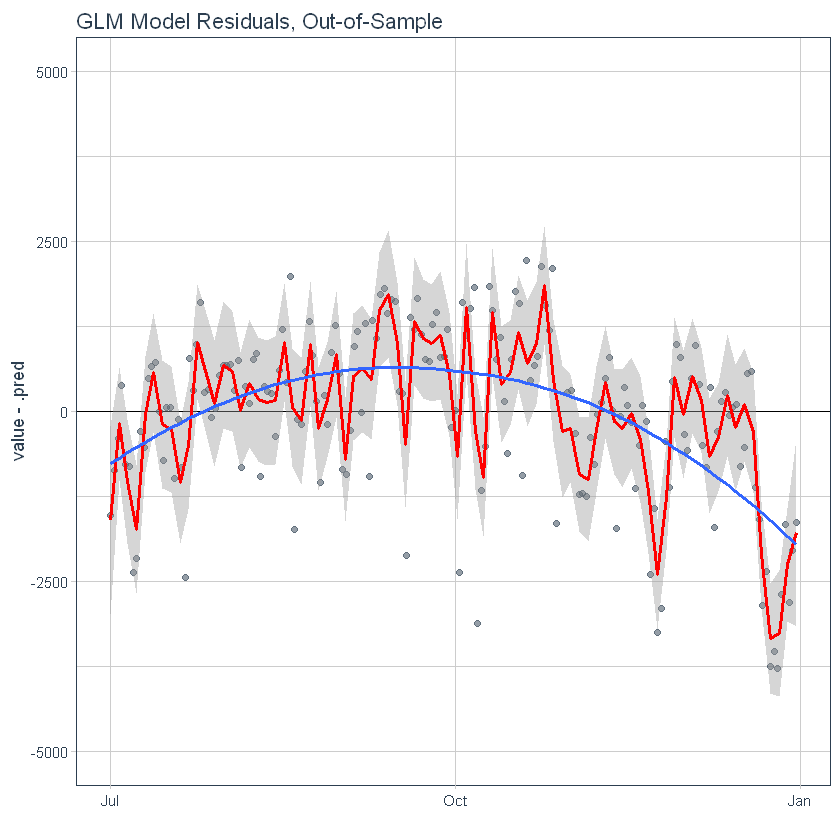

In [17]:
prediction_tbl %>%
    ggplot(aes(x = date, y = value - .pred)) +
    geom_hline(yintercept = 0, color = "black") +
    geom_point(color = palette_light()[[1]], alpha = 0.5) +
    geom_smooth(span = 0.05, color = "red") +
    geom_smooth(span = 1.00, se = FALSE) +
    theme_tq() +
    labs(title = "GLM Model Residuals, Out-of-Sample", x = "") +
    scale_y_continuous(limits = c(-5000, 5000))

### Forecasting Future Values

In [18]:
idx <- bikes_tbl %>% tk_index()
bikes_summary <- idx %>% tk_get_timeseries_summary()

In [19]:
bikes_summary[1:6]

n.obs,start,end,units,scale,tzone
<int>,<date>,<date>,<chr>,<chr>,<chr>
731,2011-01-01,2012-12-31,days,day,UTC


In [20]:
bikes_summary[7:12]

diff.minimum,diff.q1,diff.median,diff.mean,diff.q3,diff.maximum
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
86400,86400,86400,86400,86400,86400


In [21]:
idx_future <- idx %>% tk_make_future_timeseries(n_future = 180)

future_tbl <- tibble(date = idx_future) 

head(future_tbl)

Warning message:
"ARGUMENT DEPRECATION: `n_future` is deprecated. Please use `length_out` instead.
- `length_out` always returns `length_out` observations
- `n_future` may return fewer than `n_future` when inspect_weekdays/inspect_months and skip/insert values are included."


date
<date>
2013-01-01
2013-01-02
2013-01-03
2013-01-04
2013-01-05
2013-01-06


In [22]:
future_predictions_tbl <- workflow_glmnet %>% 
    fit(data = bikes_tbl) %>%
    predict(future_tbl) %>%
    bind_cols(future_tbl)

Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"Categorical variables used in `step_interact` should probably be avoided;  This can lead to differences in dummy variable values that are produced by `step_dummy`. Please convert all involved variables to dummy variables first."
Warning message:
"The following variables are not factor vectors and will be ignored: `date_month.lbl.L_x_date_day`, `date_month.lbl.Q_x_date_day`, `date_month.lbl.C_x_date_day`, `date_month.lbl^4_x_date_day`, `date_month.lbl^5_x_date_day`, `date_month.lbl^6_

`geom_smooth()` using formula 'y ~ x'



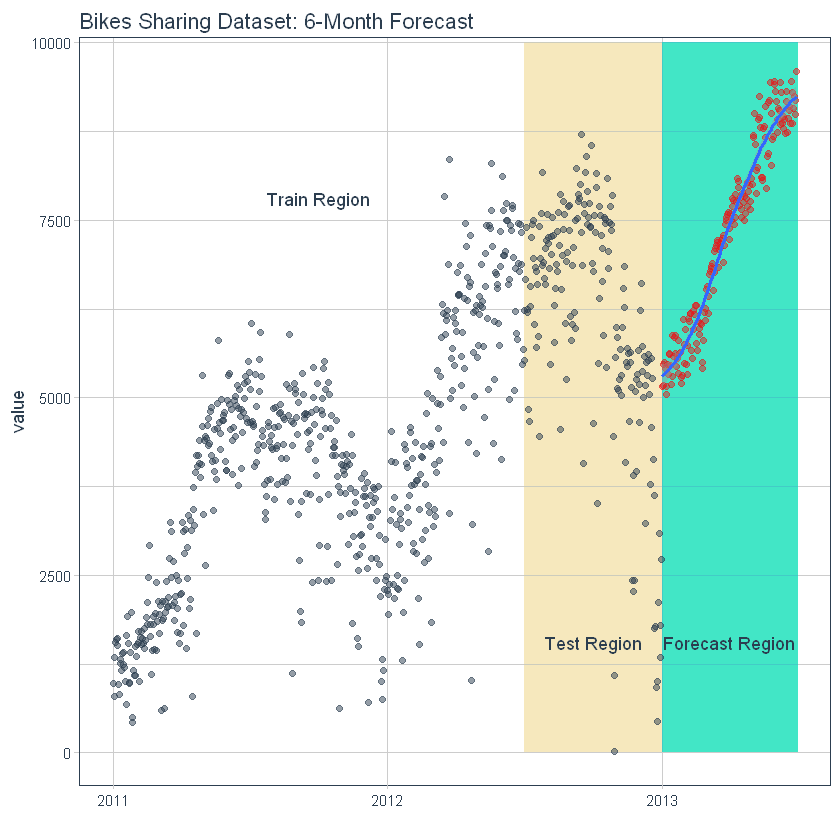

In [23]:
bikes_tbl %>%
    ggplot(aes(x = date, y = value)) +
    geom_rect(xmin = as.numeric(ymd("2012-07-01")),
              xmax = as.numeric(ymd("2013-01-01")),
              ymin = 0, ymax = 10000,
              fill = palette_light()[[4]], alpha = 0.01) +
    geom_rect(xmin = as.numeric(ymd("2013-01-01")),
              xmax = as.numeric(ymd("2013-07-01")),
              ymin = 0, ymax = 10000,
              fill = palette_light()[[3]], alpha = 0.01) +
    annotate("text", x = ymd("2011-10-01"), y = 7800,
             color = palette_light()[[1]], label = "Train Region") +
    annotate("text", x = ymd("2012-10-01"), y = 1550,
             color = palette_light()[[1]], label = "Test Region") +
    annotate("text", x = ymd("2013-4-01"), y = 1550,
             color = palette_light()[[1]], label = "Forecast Region") +
    geom_point(alpha = 0.5, color = palette_light()[[1]]) +
    geom_point(aes(x = date, y = .pred), data = future_predictions_tbl,
               alpha = 0.5, color = palette_light()[[2]]) +
    geom_smooth(aes(x = date, y = .pred), data = future_predictions_tbl,
                method = 'loess') + 
    labs(title = "Bikes Sharing Dataset: 6-Month Forecast", x = "") +
    theme_tq()

### Forecast Error

In [25]:
test_resid_sd <- prediction_tbl %>%
    summarize(stdev = sd(value - .pred))

future_predictions_tbl <- future_predictions_tbl %>%
    mutate(
        lo.95 = .pred - 1.96 * test_resid_sd$stdev,
        lo.80 = .pred - 1.28 * test_resid_sd$stdev,
        hi.80 = .pred + 1.28 * test_resid_sd$stdev,
        hi.95 = .pred + 1.96 * test_resid_sd$stdev
    )

`geom_smooth()` using formula 'y ~ x'



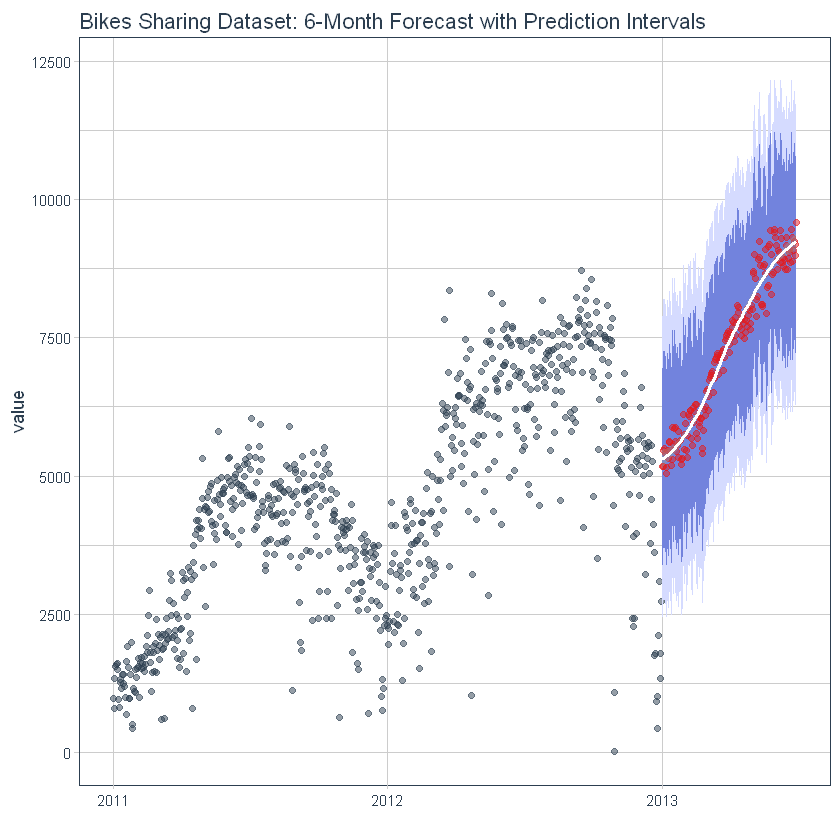

In [26]:
bikes_tbl %>%
    ggplot(aes(x = date, y = value)) +
    geom_point(alpha = 0.5, color = palette_light()[[1]]) +
    geom_ribbon(aes(y = .pred, ymin = lo.95, ymax = hi.95), 
                data = future_predictions_tbl, 
                fill = "#D5DBFF", color = NA, size = 0) +
    geom_ribbon(aes(y = .pred, ymin = lo.80, ymax = hi.80, fill = key), 
                data = future_predictions_tbl,
                fill = "#596DD5", color = NA, size = 0, alpha = 0.8) +
    geom_point(aes(x = date, y = .pred), data = future_predictions_tbl,
               alpha = 0.5, color = palette_light()[[2]]) +
    geom_smooth(aes(x = date, y = .pred), data = future_predictions_tbl,
                method = 'loess', color = "white") + 
    labs(title = "Bikes Sharing Dataset: 6-Month Forecast with Prediction Intervals", x = "") +
    theme_tq()

## END!!!